# Predictive modeling of customer bookings

---

## Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

---

### Importing libraries

In [1]:
#pip install -U imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


### Checking data types and NaNs

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

We have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Let's check the duplicates

### Duplicates

In [5]:
print('Number of duplicates :', df.duplicated().sum())
df[df.duplicated()].head()

Number of duplicates : 719


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
196,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
316,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
384,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
456,1,Internet,RoundTrip,30,85,15,Fri,AKLKUL,Malaysia,1,0,0,8.83,1
513,3,Internet,RoundTrip,109,20,4,Tue,AKLKUL,Singapore,1,0,1,8.83,0


In [6]:
# Remove duplicated rows
df = df.drop_duplicates()
print("DataFrame Information After Removing Duplicates:\n")
df.info()

DataFrame Information After Removing Duplicates:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  object 
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: f

Before we compute any statistics on the data, let's do any necessary data conversion

### Flight day conversion

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
# mapping
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["num_flight_day"] = df["flight_day"].map(mapping)
df["num_flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

### Summary of descriptive statistics

In [9]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,num_flight_day
count,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000
mean,1.590187,84.723281,23.053976,9.070676,0.668229,0.295631,0.426635,7.279974,0.149977,3.813620
std,1.016538,90.410229,33.832149,5.413099,0.470854,0.456331,0.494593,1.496390,0.357052,1.991913
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.670000,0.000000,1.000000
25%,1.000000,21.000000,5.000000,5.000000,0.000000,0.000000,0.000000,5.620000,0.000000,2.000000
50%,1.000000,51.000000,17.000000,9.000000,1.000000,0.000000,0.000000,7.570000,0.000000,4.000000
75%,2.000000,115.000000,28.000000,13.000000,1.000000,1.000000,1.000000,8.830000,0.000000,5.000000
max,9.000000,867.000000,778.000000,23.000000,1.000000,1.000000,1.000000,9.500000,1.000000,7.000000


### Correlations

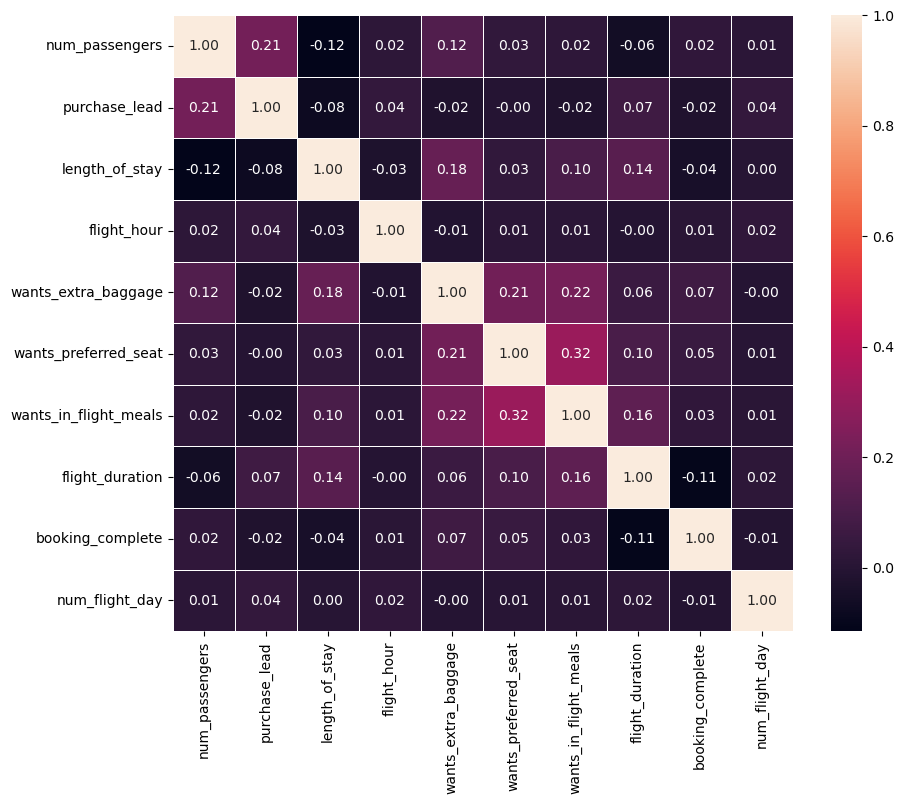

In [10]:
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.show()

### Numerical features

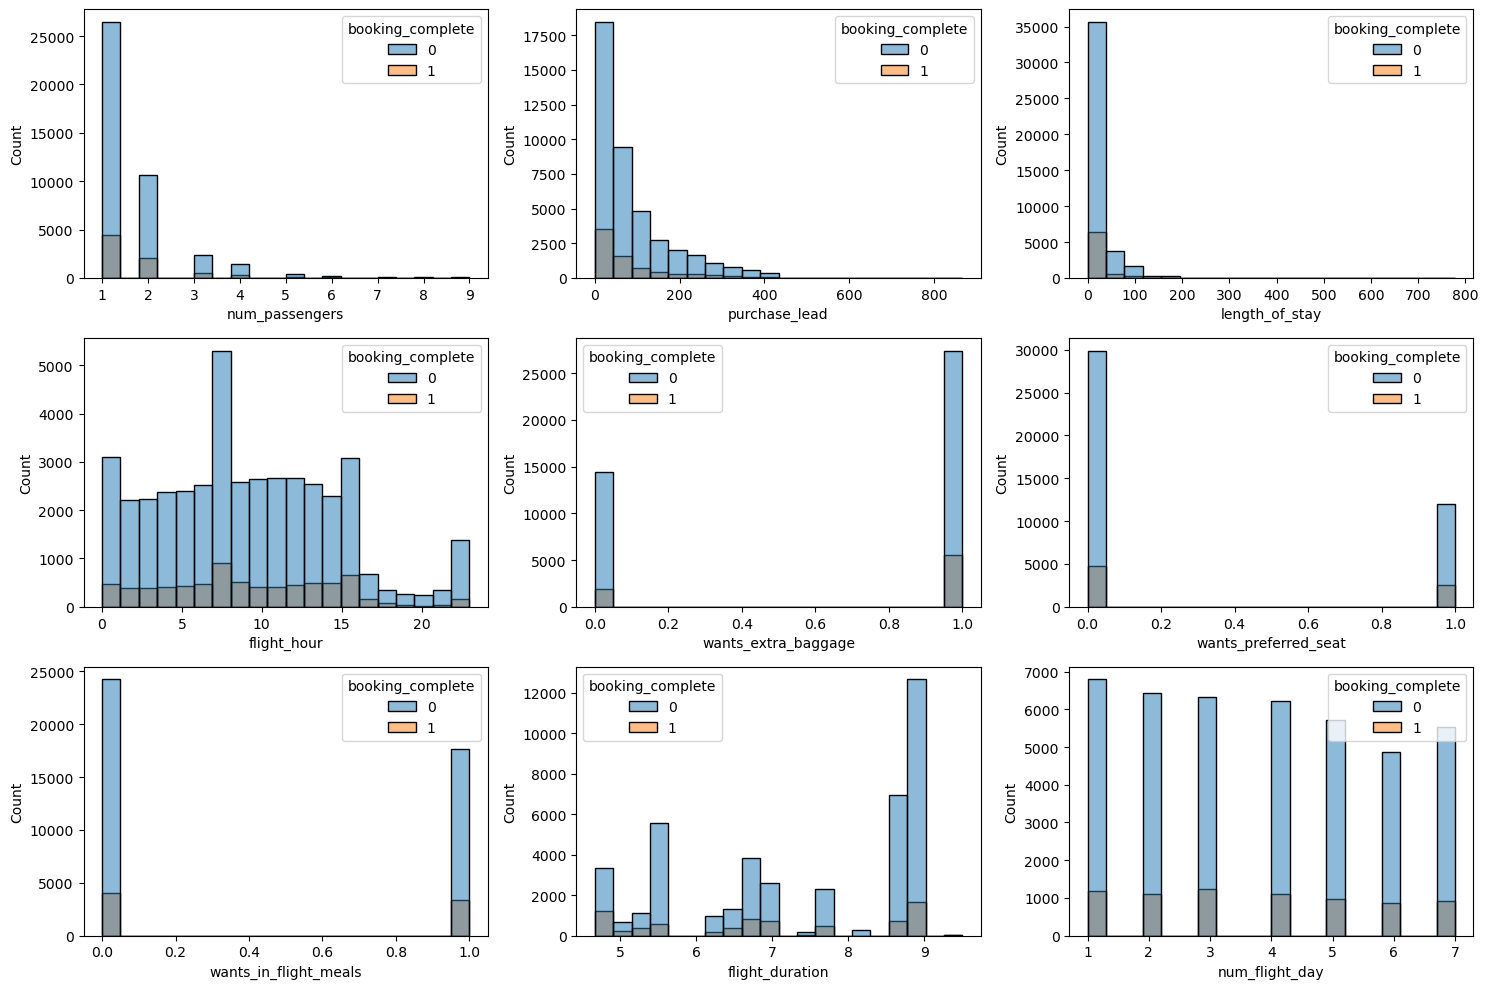

In [11]:
# Extract numerical features from df
numerical_features = df.select_dtypes(include='number')

# Drop nb_flight_day
viz = numerical_features.drop('booking_complete', axis=1)

# Determine the number of numerical features
num_features = len(viz.columns)

# Visualize the distribution of numerical features with hue
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(viz.columns):
    sns.histplot(data=df, x=col, bins=20, color='skyblue', hue='booking_complete', ax=axes[i])

plt.tight_layout()
plt.show()

### Categorical features

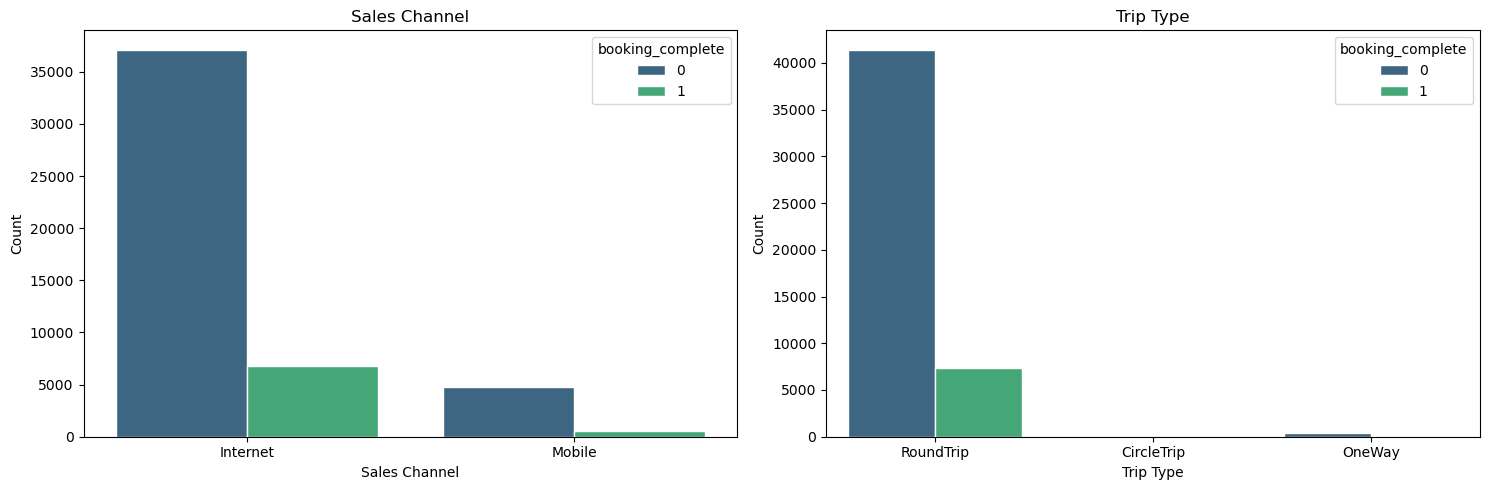

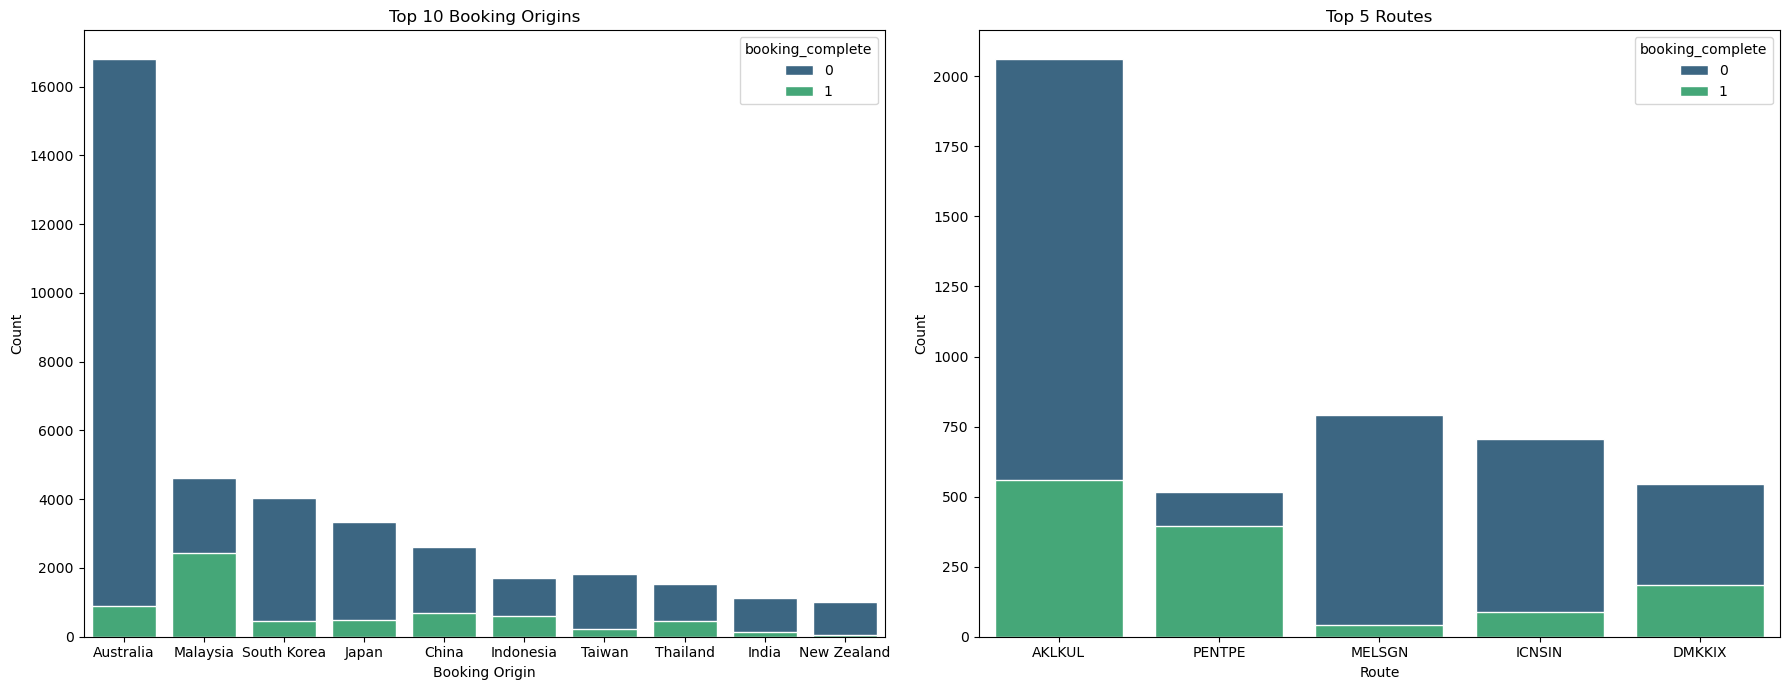

In [12]:
# Create subplots with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Countplot for 'sales_channel'
sns.countplot(x='sales_channel', data=df, hue='booking_complete', edgecolor='w', dodge=True, palette='viridis', ax=axes[0])
axes[0].set_title('Sales Channel')
axes[0].set_xlabel('Sales Channel')
axes[0].set_ylabel('Count')

# Countplot for 'trip_type'
sns.countplot(x='trip_type', data=df, hue='booking_complete', palette='viridis', dodge=True, edgecolor='w', ax=axes[1])
axes[1].set_title('Trip Type')
axes[1].set_xlabel('Trip Type')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

# Countplots for 'booking_origin' and 'route'
top_booking = df['booking_origin'].value_counts().nlargest(10).index
top_route = df['route'].value_counts().nlargest(5).index

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Bar chart for Booking Origins with hue
sns.countplot(x='booking_origin', data=df[df['booking_origin'].isin(top_booking)], order=top_booking, dodge=False, hue='booking_complete', ax=axes[0], edgecolor='w', palette='viridis')
axes[0].set_title('Top 10 Booking Origins')
axes[0].set_xlabel('Booking Origin')
axes[0].set_ylabel('Count')

# Bar chart for Routes with hue
sns.countplot(x='route', data=df[df['route'].isin(top_route)], order=top_route, dodge=False, hue='booking_complete', ax=axes[1], edgecolor='w', palette='viridis')
axes[1].set_title('Top 5 Routes')
axes[1].set_xlabel('Route')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

---
## Building the predictive model

### Assumptions for Random Forest:
1. **Independent Features:** the algorithm assumes that the individual decision trees within the forest are built on independent features. This helps in maintaining the diversity and effectiveness of the ensemble.

2. **Balanced Data:** the model performs well when the classes in the target variable are balanced. Extreme class imbalances may lead to biased predictions, particularly in the minority class.

### Checking the balance of the target variable

In [13]:
# Calculate the number of observations in each class
num_booking_complete_0 = df['booking_complete'].value_counts().get(0, 0)
num_booking_complete_1 = df['booking_complete'].value_counts().get(1, 0)

# Calculate the proportion
total_instances = len(df)
ratio_booking_complete_0 = num_booking_complete_0 / total_instances * 100
ratio_booking_complete_1 = num_booking_complete_1 / total_instances * 100

print(f"Number of booking_complete equal to 0: {num_booking_complete_0} ({ratio_booking_complete_0:.2f}%)")
print(f"Number of booking_complete equal to 1: {num_booking_complete_1} ({ratio_booking_complete_1:.2f}%)")

Number of booking_complete equal to 0: 41890 (85.00%)
Number of booking_complete equal to 1: 7391 (15.00%)


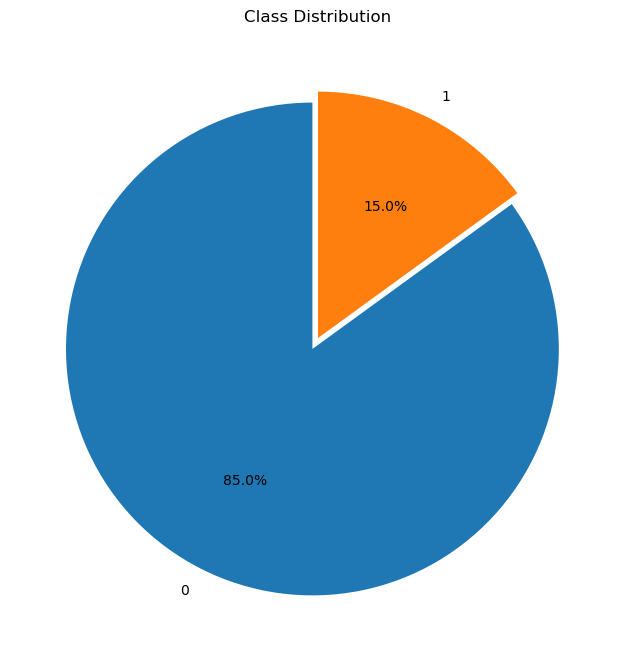

In [14]:
# Visualization
class_distribution = df['booking_complete'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90, explode=(0.05, 0))
plt.title('Class Distribution')
plt.show()

### One-hot encoding

In [15]:
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['sales_channel', 'trip_type', 'route', 'booking_origin'])

# Split the dataset into features (X) and target variable (y)
X = df_encoded.drop(['booking_complete', 'flight_day'], axis=1)
y = df_encoded['booking_complete']

### Splitting the dataset

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Oversampling the minority class with SMOTE

In [17]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [18]:
# Count the occurrences of each class in the combined dataset
class_distribution_smote = y_train_smote.value_counts()

# Print the class distribution
print("Class distribution after SMOTE:")
print(class_distribution_smote)

Class distribution after SMOTE:
0    33513
1    33513
Name: booking_complete, dtype: int64


### Splitting the dataset and training the model

In [19]:
# Train a Random Forest Classifier on the oversampled data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=0)

### Cross-validation

In [20]:
# Cross-validation
cv_accuracy = cross_val_score(rf_classifier, X_train_smote, y_train_smote, cv=2, scoring='accuracy')
cv_precision = cross_val_score(rf_classifier, X_train_smote, y_train_smote, cv=2, scoring='precision')
cv_recall = cross_val_score(rf_classifier, X_train_smote, y_train_smote, cv=2, scoring='recall')
cv_f1 = cross_val_score(rf_classifier, X_train_smote, y_train_smote, cv=2, scoring='f1')

print("Cross-Validation Metrics:")
print(f"Accuracy: {cv_accuracy.mean():.4f}")
print(f"Precision: {cv_precision.mean():.4f}")
print(f"Recall: {cv_recall.mean():.4f}")
print(f"F1-Score: {cv_f1.mean():.4f}")

# Comparison with the test set
y_pred = rf_classifier.predict(X_test)
print("\nComparison with the Test Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Cross-Validation Metrics:
Accuracy: 0.8677
Precision: 0.8934
Recall: 0.8447
F1-Score: 0.8589

Comparison with the Test Set Metrics:
Accuracy: 0.8279
Precision: 0.3956
Recall: 0.2764
F1-Score: 0.3254


### Test set

Accuracy: 0.8279
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8377
           1       0.40      0.28      0.33      1480

    accuracy                           0.83      9857
   macro avg       0.64      0.60      0.61      9857
weighted avg       0.81      0.83      0.81      9857

Confusion Matrix:
[[7752  625]
 [1071  409]]


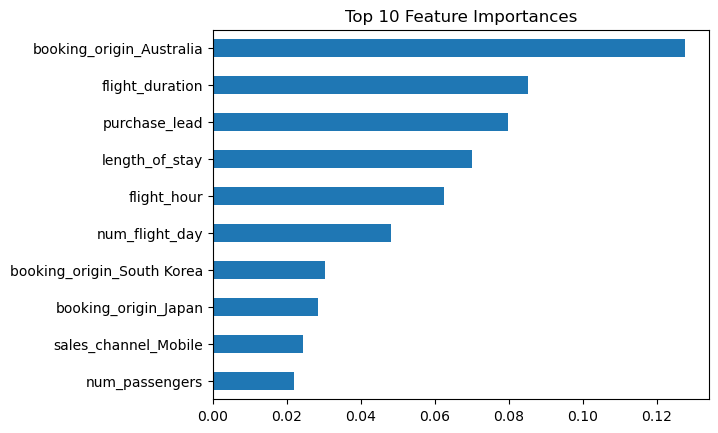

In [21]:
# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output performance metrics and visualizations
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

# Feature importance plot
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
feature_importances.nlargest(10).sort_values().plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()